In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import os
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

In [2]:
embeddings_CCD = pd.read_csv("/volatile/jl277509/Runs/02_STS_babies/Program/Output/PCS_FINAL_MODEL/19-12-25_3/CCD_random_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB = pd.read_csv("/volatile/jl277509/Runs/02_STS_babies/Program/Output/PCS_FINAL_MODEL/19-12-25_3/UKB_random_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,15.592494,34.494900,8.719974,84.042755,-2.338658,17.109613,17.615273,-1.569066,-0.724397,-3.401615,...,21.493185,-21.094856,-16.412336,0.503177,15.058713,-6.507754,-56.560260,-0.500706,22.970040,-0.897924
sub-1000458,21.859705,41.393238,16.137548,58.983418,14.475472,34.597996,-0.670761,-17.257439,2.672007,-8.064828,...,33.590267,-7.286129,-16.044346,-6.735470,13.279847,23.086065,-18.885305,15.098557,15.267213,-12.603914
sub-1000575,66.839590,-7.664413,16.941942,52.955128,-38.902386,-7.481332,-6.376166,2.011489,2.837864,8.470457,...,-26.563917,4.246506,-2.606314,-13.200418,0.386144,-7.431461,7.049025,20.465460,15.058507,21.503077
sub-1000606,41.851505,10.870255,31.636250,55.456170,13.537527,4.086966,33.851727,-4.856818,-23.671595,-4.551562,...,-15.102870,-13.294502,-0.053844,6.308680,26.031740,-13.061463,-39.270817,3.099191,3.324039,5.225338
sub-1000963,16.002398,13.636017,15.947115,71.199370,1.879433,28.217922,1.475944,6.490414,7.099989,1.988958,...,7.824328,-4.322985,-28.375147,31.262850,11.012692,-0.501506,-29.956993,21.468794,20.046604,-0.328055


In [13]:
CCD_labels = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/CCD/ccd_labels.csv')
CCD_labels = CCD_labels.set_index('Subject')
CCD_labels.index.name='ID'

In [23]:
emb = embeddings_CCD.merge(CCD_labels, left_index=True, right_index=True)
embeddings_CCD_controls = (emb.loc[emb['CCD']==0]).drop('CCD', axis=1)
embeddings_CCD_anomaly = (emb.loc[emb['CCD']==1]).drop('CCD', axis=1)

In [24]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)

scl_bdd_ccd_control = scaler.transform(embeddings_CCD_controls)
scl_bdd_ccd_anomaly = scaler.transform(embeddings_CCD_anomaly)
scl_bdd_ukb = scaler.transform(embeddings_UKB)

In [25]:
reducer2D = umap.UMAP(n_components=2)

reducer2D.fit(scl_bdd_ukb)

bdd_2D_CCD_control = reducer2D.transform(scl_bdd_ccd_control)
bdd_2D_CCD_anomaly = reducer2D.transform(scl_bdd_ccd_anomaly)
bdd_2D_UKB = reducer2D.transform(scl_bdd_ukb)

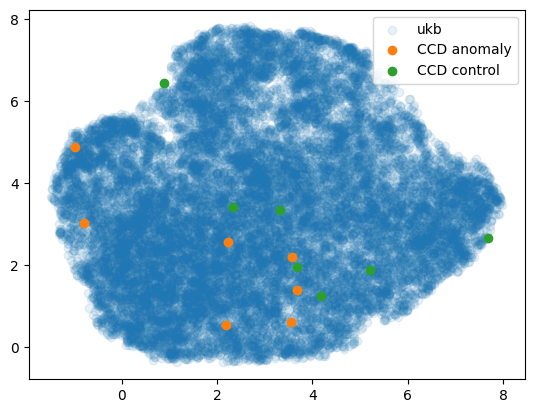

In [29]:
fig, ax = plt.subplots()
ax.scatter(bdd_2D_UKB[:, 0], bdd_2D_UKB[:, 1], alpha=0.1, label='ukb')
ax.scatter(bdd_2D_CCD_anomaly[:, 0], bdd_2D_CCD_anomaly[:, 1], alpha=1, label='CCD anomaly')
ax.scatter(bdd_2D_CCD_control[:, 0], bdd_2D_CCD_control[:, 1], alpha=1, label='CCD control')
plt.legend()
plt.show()

# distance in UMAP

In [43]:
all_subs_bdd = np.vstack((bdd_2D_UKB, bdd_2D_CCD_control, bdd_2D_CCD_anomaly))

In [58]:
for metric in 'euclidean', 'cosine':
    print(metric)
    ukb_dist = pairwise_distances(all_subs_bdd, metric=metric)
    avges = []
    for i in range(100):
        av = np.mean(ukb_dist[:, np.random.randint(0, 21045, 7)])
        avges.append(av)
    print(f'Average pairwise distance in ukb {np.mean(avges), np.std(avges)}')
    print(f'Average pairwise distance between CCD controls and ukb: {np.mean(ukb_dist[:, 21045:21052])}')
    print(f'Average pairwise distance between CCD anomalies and ukb: {np.mean(ukb_dist[:, 21052:21059])}')

euclidean
Average pairwise distance in ukb (3.7323594, 0.2167197)
Average pairwise distance between CCD controls and ukb: 3.6455416679382324
Average pairwise distance between CCD anomalies and ukb: 3.655090093612671
cosine
Average pairwise distance in ukb (0.20644602, 0.039421376)
Average pairwise distance between CCD controls and ukb: 0.20334406197071075
Average pairwise distance between CCD anomalies and ukb: 0.2937391698360443


CCD subjects are far from UKB using cosine metric ?

In [127]:
pairwise_dists = pairwise_distances(all_subs_bdd, metric='cosine')

In [128]:
np.sum(pairwise_dists==0)
# bizarre: pas mal de sujets sont alignés ??, dans la UMAP...

131389

In [130]:
sorted_dists = np.sort(pairwise_dists)

In [138]:
# on peut couper au k-ième plus proche voisin et regarder la distribution de distance
k = 50
distance_to_kth_neighbour = sorted_dists[:, k]
avges = []
for i in range(10000):
    av = np.mean(distance_to_kth_neighbour[np.random.randint(0, 21045, 7)])
    avges.append(av)
print(f'Average distance to {k}th neighboor in ukb {np.mean(avges):.5f}, {np.std(avges):.5f}')
print(f'Average distance to {k}th neighboor in CCD controls: {np.mean(distance_to_kth_neighbour[21045:21052]):.5f}')
print(f'Average distance to {k}th neighboor in CCD anomaly: {np.mean(distance_to_kth_neighbour[21052:21059]):.5f}')

Average distance to 50th neighboor in ukb 0.00005, 0.00039
Average distance to 50th neighboor in CCD controls: 0.00000
Average distance to 50th neighboor in CCD anomaly: 0.00001


# distances in latent space

In [148]:
all_subs_bdd = np.vstack((scl_bdd_ukb, scl_bdd_ccd_control, scl_bdd_ccd_anomaly))

In [150]:
for metric in 'euclidean', 'cosine':
    print(metric)
    ukb_dist = pairwise_distances(all_subs_bdd, metric=metric)
    avges = []
    for i in range(100):
        av = np.mean(ukb_dist[:, np.random.randint(0, 21045, 7)])
        avges.append(av)
    print(f'Average pairwise distance in ukb {np.mean(avges), np.std(avges)}')
    print(f'Average pairwise distance between CCD controls and ukb: {np.mean(ukb_dist[:, 21045:21052])}')
    print(f'Average pairwise distance between CCD anomalies and ukb: {np.mean(ukb_dist[:, 21052:21059])}')

euclidean
Average pairwise distance in ukb (22.379375432372303, 0.30068773053035824)
Average pairwise distance between CCD controls and ukb: 21.967764845245892
Average pairwise distance between CCD anomalies and ukb: 21.7956521161252
cosine
Average pairwise distance in ukb (0.9998578848940147, 0.00120681340752991)
Average pairwise distance between CCD controls and ukb: 1.0005575867335879
Average pairwise distance between CCD anomalies and ukb: 0.9995844326838803


In [151]:
pairwise_dists = pairwise_distances(all_subs_bdd, metric='cosine')

In [152]:
sorted_dists = np.sort(pairwise_dists)

In [166]:
np.percentile(avges, 99.9)

0.2789399079429927

In [181]:
# on peut couper au k-ième plus proche voisin et regarder la distribution de distance
k = 20
distance_to_kth_neighbour = sorted_dists[:, k]
avges = []
for i in range(10000):
    av = np.mean(distance_to_kth_neighbour[np.random.randint(0, 21045, 7)])
    avges.append(av)
print(f'Average distance to {k}th neighboor in ukb {np.mean(avges):.5f}, std: {np.std(avges):.5f}, 99th percentile: {np.percentile(avges, 99)}, 99.9th percentile: {np.percentile(avges, 99.9)}, 99.99th percentile: {np.percentile(avges, 99.99)}')
print(f'Average distance to {k}th neighboor in CCD controls: {np.mean(distance_to_kth_neighbour[21045:21052]):.5f}, std: {np.std(distance_to_kth_neighbour[21045:21052]):.5f}')
print(f'Average distance to {k}th neighboor in CCD anomaly: {np.mean(distance_to_kth_neighbour[21052:21059]):.5f}, std: {np.std(distance_to_kth_neighbour[21052:21059]):.5f}')
print(f'Individual distance in CCD: {distance_to_kth_neighbour[21052:21059]}')

Average distance to 20th neighboor in ukb 0.22711, std: 0.01272, 99th percentile: 0.25745722238226515, 99.9th percentile: 0.27015230694588216, 99.99th percentile: 0.279224459712837
Average distance to 20th neighboor in CCD controls: 0.24527, std: 0.02120
Average distance to 20th neighboor in CCD anomaly: 0.28967, std: 0.02790
Individual distance in CCD: [0.25161327 0.29016037 0.30362993 0.32765457 0.31679985 0.28849917
 0.24934949]


When considering 1000th neighbours, CCD is in the distribution, but for 25 neighbours, they are not.

What about individual subjects ? 2/7 sont plutôt dans la distribution, au moins de celle des contrôles CCD...

# PCA to 20 dimensions ?